# Annotation of artefacts

## Introduction

We will show here how artefacts can be identified and then annotated. The annotations will be represented in the FIF data file. Sections or trials will not be rejected at this stage; rather the annotations may be used later. For instance, they can be used to reject trials with eyeblinks or muscle contractions depending on their relevance for the analysis.  

## Preparation

Import the relevant modules: 

In [1]:
import os.path as op
import os
import sys
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import annotate_muscle_zscore
import matplotlib.pyplot as plt


### File overview
The chapter relies on the input files (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
~~~
and generates the output files:
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif

<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.csv
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.csv
~~~

Set the path and load the FIF-files: 

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
max_suffix = 'raw_sss'
ann_suffix = 'ann'

deriv_root = '/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing'

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=max_suffix, 
            root=deriv_root, extension='.fif', check=False)


# The annotations will be stored in these files
deriv_fname_fif = bids_path.basename.replace(max_suffix, ann_suffix) # fif output filename

deriv_fname_fif_1 = op.join(bids_path.directory, deriv_fname_fif)
deriv_fname_fif_2 = deriv_fname_fif_1.replace('run-01', 'run-02')

deriv_fname_csv_1 = deriv_fname_fif_1.replace('fif', 'csv') # csv output filename
deriv_fname_csv_2 = deriv_fname_csv_1.replace('run-01', 'run-02') 


print(bids_path)
print(deriv_fname_fif_1)
print(deriv_fname_csv_1)

/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.csv


In [3]:
raw1 = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif...
    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...


/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/1752485552.py:1: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw1 = read_raw_bids(bids_path=bids_path,
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/1752485552.py:1: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw1 = read_raw_bids(bids_path=bids_path,
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/1752485552.py:1: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preproc

## Identifying eye blinks

Here we show how the artefacts associated with eye blinks can be marked automatically on the basis of the vertical EOG channel (EOG001 in our case). After bandpass filtering the EOG signal between 1 - 10 Hz, the threshold for blink detection is determined according to:

$$ (max(vEOG) - min(vEOG)) / 4 $$

 Segments being 500 ms long starting 250 ms prior to exceeding the threshold are annotated as blinks. 

In [4]:
eog_events = mne.preprocessing.find_eog_events(raw1, ch_name='EOG001') 

Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG001 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 543 significant peaks
Number of EOG events detected: 543


In total, 543 events were indentified as blinks. In order to write these events on the dataset, we need to create an Annotation object with contains the onset of each blink, their durations and a description (i.e., tag) of the type of event:

In [5]:
n_blinks = len(eog_events)
onset = eog_events[:, 0] / raw1.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
description = ['blink'] * n_blinks
orig_time = raw1.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)

## Finding muscle artefacts

Muscle artefacts are identified from the magnetometer data filtered in the 110 - 140 Hz range. The data are subsequently z-scored. If they exceed the value *threshold_muscle*, the corresponding section of data is annotated as muscle artifact. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.

In [6]:
threshold_muscle = 10  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw1, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.0s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



To check whether the threshold used for the muscle annotation is good for the current data, we plot the z-scores across the recording. The threshold is indicated by a red line.

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity (threshold = 10)')]

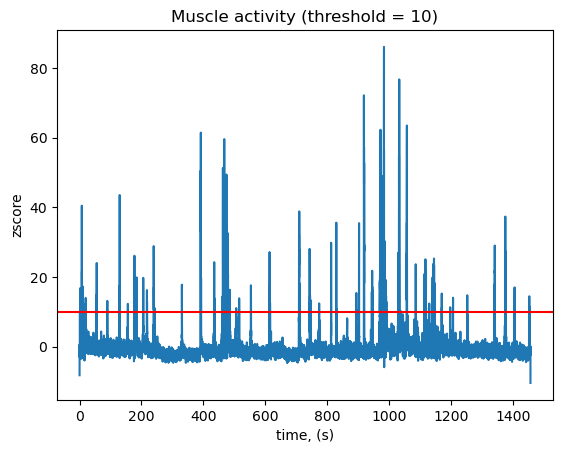

In [7]:
%matplotlib inline
fig1, ax = plt.subplots()
ax.plot(raw1.times, scores_muscle);
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity (threshold = %s)' % threshold_muscle)

From this figure we can see that the threshold is above the baseline level. Still, it captures all the picks in high-gamma activity representing muscle artifacts. 

## Include annotations in dataset and inspect

Now mark all the annotations in the data set.


*Calling set_annotations() replaces any annotations currently stored in the Raw object. To prevent that, we first extract their annotations and then combine them together with the blink and muscle annotations*.

In [8]:
annotations_event = raw1.annotations 
raw1.set_annotations(annotations_event + annotations_blink + annotations_muscle)

/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/3937126658.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw1.set_annotations(annotations_event + annotations_blink + annotations_muscle)


<Raw | sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif, 343 x 1457000 (1457.0 s), ~3.72 GB, data loaded>

To inspect the annotations write:

In [9]:
%matplotlib inline
raw1.plot(start=50)

Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none
Channels marked as bad:
none


To specifically inspect the ocular artefacts display the EOG sensors: 

In [10]:
# Set the channel type as 'eog'
raw1.set_channel_types({'EOG001': 'eog'})
raw1.set_channel_types({'EOG002': 'eog'})

eog_picks = mne.pick_types(raw1.info, meg=False, eog=True)

scl = dict(eog=500e-6)
raw1.plot(order=eog_picks, scalings=scl, start=50)

/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/255727686.py:2: RuntimeWarning: The unit for channel(s) EOG001 has changed from NA to V.
  raw1.set_channel_types({'EOG001': 'eog'})
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/255727686.py:3: RuntimeWarning: The unit for channel(s) EOG002 has changed from NA to V.
  raw1.set_channel_types({'EOG002': 'eog'})


Using pyopengl with version 3.1.6


The sensor layout of the sensors in the MEGIN system will be of use for answering the questions below (adapted from Hu et al., 2018).


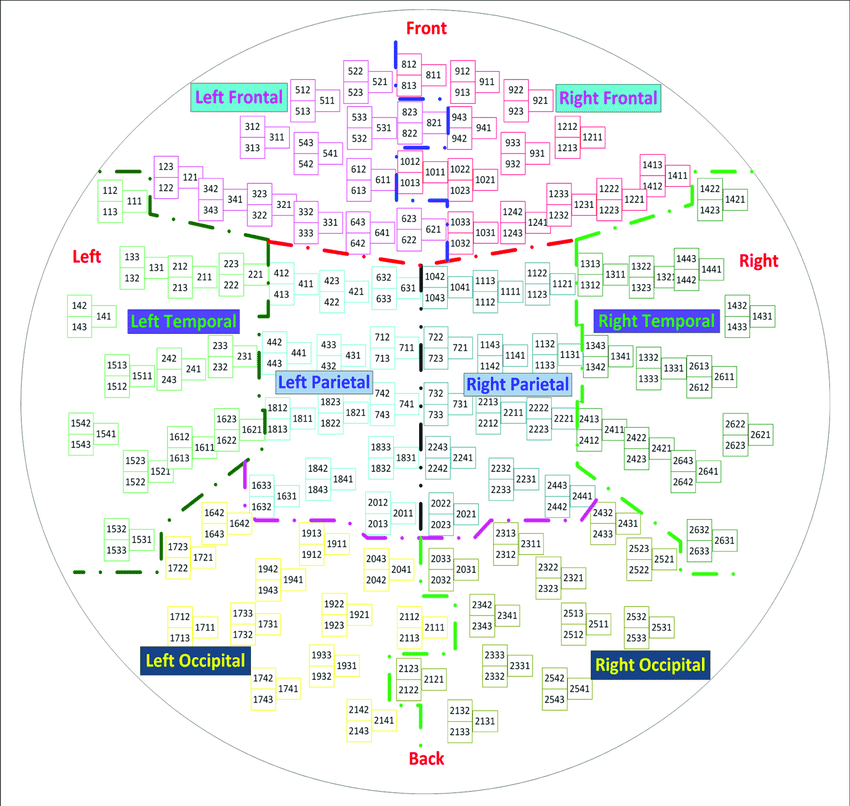


**Question 1:** In which sensors are the muscle artefacts particularly strong? Explain why.

**Question 2:** In which sensors are the ocular artefacts particularly strong? Explain why.

**Question 3:** Is the hEOG or vEOG best for identifying saccades? Explain why. 


## Save the artefact annotations

Save the annotations in a file to be used in the subsequent sections:

In [11]:
raw1.save(deriv_fname_fif_1, overwrite=True)
raw1.annotations.save(deriv_fname_csv_1, overwrite=True)

Overwriting existing file.


Writing /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif


/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/3888226814.py:1: RuntimeWarning: This filename (/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw1.save(deriv_fname_fif_1, overwrite=True)


Closing /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
[done]
Overwriting existing file.


## Perform artefact annotation on the rest of the dataset 

Now perform the annotation operations on the second FIF-file:

In [12]:
bids_path.update(run='02')
print(bids_path.basename)

raw2 = read_raw_bids(bids_path=bids_path, 
                      extra_params={'preload':True},
                      verbose=True) 

# Blinks
eog_events = mne.preprocessing.find_eog_events(raw2, ch_name='EOG001') 
n_blinks = len(eog_events)  
onset = eog_events[:, 0] / raw2.info['sfreq'] - 0.25
onset -= raw2._first_time  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks  
orig_time = raw2.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)

# Muscle
threshold_muscle = 10
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw2, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

# Annotate the data files
raw2.set_annotations(raw2.annotations + annotations_blink + annotations_muscle)

# Save 
raw2.save(deriv_fname_fif_2, overwrite=True)
raw2.annotations.save(deriv_fname_csv_2, overwrite=True)

sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
Opening raw data file /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades


/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:4: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw2 = read_raw_bids(bids_path=bids_path,
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:4: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw2 = read_raw_bids(bids_path=bids_path,
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:4: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preproc

Selecting channel EOG001 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 487 significant peaks
Number of EOG events detected: 487
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.9s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)

Overwriting existing file.
Writing /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif


/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:25: RuntimeWarning: Omitted 487 annotation(s) that were outside data range.
  raw2.set_annotations(raw2.annotations + annotations_blink + annotations_muscle)
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:28: RuntimeWarning: This filename (/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw2.save(deriv_fname_fif_2, overwrite=True)


Closing /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
[done]
Overwriting existing file.


## Pregistration and publication

Preregistration: Report the the type of artifacts being annotated as well as the threshold selections. 


Publication, example:

"Artefacts were annotated in the raw data such that they later could be used to reject trials if relevant. Ocular artefacts were identified in the vertical EOG data (bandpass filtered at 1 - 10 Hz) according to segments exceeding a threshold defined according to (max(EOG) - min(EOG))/4. Ocular artefacts were considered 500 ms long centred around the time they exceeded the threshold. Muscle artefacts were identified in magnetometers data bandpass filtered at 110 - 140 Hz. The filtered data were z-scored and segments exceeding a z-score of 10 were annotated as muscle artefacts. " 

## References 

Muthukumaraswamy, S. (2013). High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations. Frontiers in Human Neuroscience, 7:138

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616

